Mass ratio for  APOGEE_V1481.tbl  is  (0.047632773020062164, 30.060404950124525)
Periodogram peaks above a power of 0.25: [ 0.22147477  0.40127955  0.54112771  0.60106263  0.66099756  0.86078064
  1.18043357  1.42017327  1.50008651  1.59997805  1.79976113  1.87967436
  1.9595876   2.03950083  2.11941406  2.21930561  2.65882839  2.99845963
  3.3980258   6.35481543]


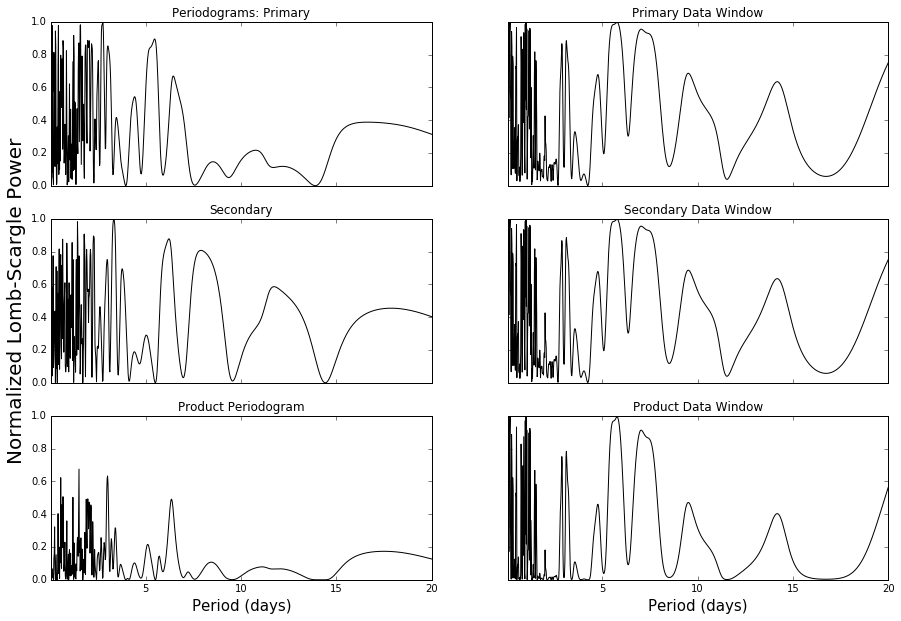

In [9]:
#import-libraries-and-data---------------------------------------------------------------------------------------#
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import lombscargle
%matplotlib inline
filename     = 'APOGEE_V1481.tbl'
system       = np.genfromtxt(filename, skip_header=1, usecols=(0, 1, 2))

#define-variable--------------------------------------------------------------------------------------------------#

JD, RVp, RVs = [datum[0] for datum in system], [datum[1] for datum in system], [datum[2] for datum in system]
JDp, JDs     = JD, JD
samples      = 1000
max_period   = 20

#dfine-functions-------------------------------------------------------------------------------------------------#

#This periodogram function was taken from Jake Vanderplas' article "Fast Lomb-Scargle Periodograms in Python"
def periodogram(t, rv, f):
    t = np.array(t)
    rv = np.array(rv)
# lower limit of periods range set to one hour
#    delta_t = np.inf 
#    for i in range(0, len(t)-2):
#        if t[i+1]-t[i] < delta_t and t[i+1]-t[i] != 0:
#            delta_t = t[i+1]-t[i]
    periods = np.linspace(0.04167, max_period, num = f)

    # convert period range into frequency range
    ang_freqs = 2 * np.pi / periods

    # compute the (unnormalized) periodogram
    # note pre-centering of y values!
    powers = lombscargle(t, rv - rv.mean(), ang_freqs)

    # normalize the power
    N = len(t)
    powers *= 2 / (N * rv.std() ** 2)
    return periods, powers

#slighty altered periodogram function, computes data window for a set of visits
def data_window(t, f):
    t = np.array(t)
#    delta_t = np.inf 
#    for i in range(0, len(t)-2):
#        if t[i+1]-t[i] < delta_t and t[i+1]-t[i] != 0:
#            delta_t = t[i+1]-t[i]
    periods = np.linspace(0.04167, max_period, num = f)

    # convert period range into frequency range
    ang_freqs = 2 * np.pi / periods

    # compute the (unnormalized) periodogram
    # note pre-centering of y values!
    powers = lombscargle(t, np.ones(len(t)), ang_freqs)

    # normalize the power
    N = len(t)
    powers *= 2 / N
    return periods, powers

#function computes and returns mass ratio
def massRatio():
    p =[datum[1] for datum in system if not np.isnan(datum[1]+datum[2])]
    s =[datum[2] for datum in system if not np.isnan(datum[1]+datum[2])]
    m,b = np.polyfit(s, p, 1)
    return -m, b

#this function removes nan cells from the bad RV visits, and deletes the accompanying JD element 
#from a copy tied to the specific rv list
def adjustment(t, rv):
    adjusted_t = np.asarray(t)
    for i in range(0, len(t)-1):
        if i == len(rv):
            break
        if np.isnan(rv[i]):
            rv         = np.delete(rv, i)
            adjusted_t = np.delete(adjusted_t, i)
    return adjusted_t, rv

#function converts measurements in time into measurements in orbital phase (from 0-1)
#function is only useful after T and P have been determined
def phases(P, T, times):
    phased_Times = np.array([])
    for i in range(0, len(times)):
        phased_Times = np.append(phased_Times, ((times[i])-T)/P-int(((times[i])-T)/P))
        if phased_Times[i] < 0:
            phased_Times[i] = phased_Times[i]+1
    return phased_Times

#function finds local maxima above a specified cutoff power
def maxima(cutoff):
    power = y*y2
    maxima = np.array([])
    for i in range(1, len(power)-2):
        if power[i-1] < power[i] and power[i] > power[i+1] and power[i] > cutoff:
            maxima = np.append(maxima, x[i])
    return maxima

#now-do-things!--------------------------------------------------------------------------------------------------#

#check RV measurements for the need to be adjusted and adjust them if so
for i in range(0, len(JD)-1):
    if np.isnan(system[i][1]):
        JDp, RVp = adjustment(JD, RVp)
        break
        
for i in range(0, len(JD)-1):
    if np.isnan(system[i][2]):
        JDs, RVs = adjustment(JD, RVs)
        break
        
# plot the results
x, y  = periodogram(JDp, RVp, samples)
y2    = periodogram(JDs, RVs, samples)[1]
y3,y4 = data_window(JDp, samples)[1], data_window(JDs, samples)[1]

fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3, 2, sharex='col', sharey='row')
ax1.plot(x, y, 'k')
ax1.set_title('Periodograms: Primary')
ax1.set_xlim(1/24, max_period)
ax4.set_xlim(1/24, max_period)
ax2.plot(x, y2, 'k')
ax2.set_title('Secondary')
ax3.plot(x, y*y2, 'k')
ax3.set_title('Product Periodogram')
ax4.plot(x, y3, 'k')
ax4.set_title('Primary Data Window')
ax5.plot(x, y4, 'k')
ax5.set_title('Secondary Data Window')
ax6.plot(x, y3*y4, 'k')
ax6.set_title('Product Data Window')
ax3.set_xlabel('Period (days)', size='15')
ax6.set_xlabel('Period (days)', size='15')
ax2.set_ylabel('Normalized Lomb-Scargle Power', size='20')
fig.set_figheight(10)
fig.set_figwidth(15)
#plt.savefig(filename + ' periodogram.pdf')
print('Mass ratio for ', filename, ' is ', massRatio())
print('Periodogram peaks above a power of 0.25:',maxima(0.25))

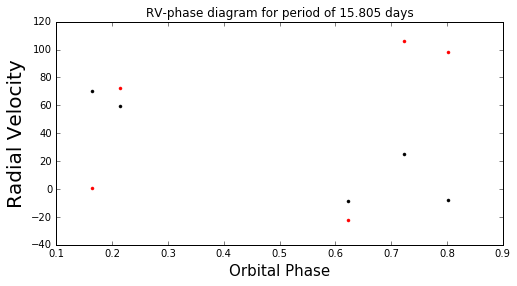

In [10]:
fig, ((ax1)) = plt.subplots(1,1, sharex='col', sharey='row')
ax1.plot(phases(maxima(0.2)[0], 0, JDp), RVp, 'k.')
ax1.plot(phases(maxima(0.2)[0], 0, JDs), RVs, 'r.')
ax1.set_title('RV-phase diagram for period of 15.805 days')
ax1.set_xlabel('Orbital Phase', size='15')
ax1.set_ylabel('Radial Velocity', size='20')
#fig.set_figheight(12)
fig.set_figwidth(8)
#plt.savefig(filename + ' RV-phase diagram.pdf')

(0.047632773020062164, 30.060404950124525)


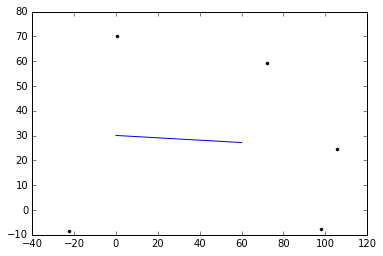

In [11]:
#below is a visualization of the mass ratio calculation
print(massRatio())
RVp = [datum[1] for datum in system if not np.isnan(datum[1]+datum[2])]
RVs = [datum[2] for datum in system if not np.isnan(datum[1]+datum[2])]
plt.plot(RVs, RVp, 'k.')
plt.plot(np.linspace(0, 60, 4), -massRatio()[0]*np.linspace(0, 60, 4)+massRatio()[1])